In [73]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import *
import random

# L'algorithme du recuit simulé

L'algorithme du recuit simulé permet de résoudre des problèmes d'optimisation non convexe, pour lesquels la méthode de descente du gradient n'est pas appropriée. On s'intéresse ici à une application au problème du voyageur de commerce (section 6.4 dans le poly).

## 1) Données numériques
On souhaite calculer le **plus court chemin cyclique** passant par toutes les capitales des états fédéraux américains (Hawaii et Alaska exclus). Ce problème provient de la collection d'exemples [TSPLIB](http://elib.zib.de/pub/mp-testdata/tsp/tsplib/tsplib.html). Les données dont on dispose sont les cordonnées géographiques des villes, regroupées dans une matrice `uscapitals_list` :

In [74]:
uscapitals_list = np.genfromtxt("uscapitals.csv", delimiter=",")

La i-ème ligne de la matrice `uscapitals_list` est le couple de coordonnées de la i-ème ville. Par exemple :

In [75]:
print(uscapitals_list[3])

[401. 841.]


Dans l'exemple que nous considérons ici, le parcours optimal est connu et stocké dans la variable `uscapitals_opt` :

In [76]:
uscapitals_opt = np.genfromtxt("uscapitals_opt.csv", delimiter=",").astype(int)-1
print(uscapitals_opt)

[ 0  7 37 30 43 17  6 27  5 36 18 26 16 42 29 35 45 32 19 46 20 31 38 47
  4 41 23  9 44 34  3 25  1 28 33 40 15 21  2 22 13 24 12 10 11 14 39  8]


Pour calculer la distance (en milles) entre les villes à partir de leurs cordonnées, on utilise la distance euclidienne classique :

In [77]:
def euclidian_dist(citya, cityb):
    return np.linalg.norm(cityb-citya)

In [78]:
uscapitals_distances = np.zeros((len(uscapitals_list),
                                 len(uscapitals_list)))
for i in range(len(uscapitals_list)):
    for j in range(len(uscapitals_list)):
        uscapitals_distances[i,j] = euclidian_dist(uscapitals_list[i], uscapitals_list[j])

In [79]:
cities = uscapitals_list
optimal = uscapitals_opt
distances = uscapitals_distances

## 2) L'algorithme
**Objectif à minimiser** Le coût $V$ d'un parcours est la somme des distances entres villes consécutives. On identifie un parcours avec une permutation $\sigma$ de l'ensemble $\{0,2,..,15\}$, que l'on représente par une liste. $\sigma(k)$ est donc la k-ème ville que l'on visite en suivant le parcours $\sigma$. On a donc :
$$
V(\sigma) = \sum_{i=1}^{n-1} d(\sigma(i), \sigma(i+1)) + d(\sigma(n), \sigma(1)) 
$$

**TODO** : La fonction `V` le tableau de l'ordre des villes `tour` et la matrice `distances`des distances entre villes, et retourne un nombre réel `c`.

In [80]:
def V(tour, distances):
    c = 0
    for i in range(len(tour)-1):
        c +=distances[tour[i],tour[i+1]]
    c += distances[tour[len(tour)-1],tour[0]]
    
    return c

**Algorithme du recuit simulé :** À chaque itération, l'algorithme propose un nouveau parcours, obtenu en tirant au hasard deux nombres $i$ et $j$ et en invertissant les villes $\sigma(i)$ et $\sigma(j)$ dans l'état courant.

**TODO** : La fonction `proposition` prend un tableau d'ordre des villes et retourne un nouveau tableau permuté. Par exemple, `proposition([0,1,2,3,4])` pourrait produire `[1,0,2,3,4]`.

In [81]:
def proposition(tour):
    prop = tour.copy()
    
    i, j = np.random.choice(len(tour),size =2, replace = False)
    
    prop[i], prop[j] = prop[j], prop[i] 
    
    return prop
print("Exemple :", [0,1,2,3,4], "->", proposition([0,1,2,3,4]))

Exemple : [0, 1, 2, 3, 4] -> [0, 1, 4, 3, 2]


Le deuxième ingrédient est le schéma de température, qui régit la décroissance de la température au cours du temps. Plusieurs choix sont possibles. On utilise pour commencer une décroissance polynomiale :

In [82]:
def T(i):
    return 300*((i+1)**(-0.03))

**TODO** : Dans la fonction suivante, on implémente l'algorithme. Les arguments sont
- la matrice des distances entre villes `distances`
- le nombre d'itérations `N_iter`
- l'état initial `initial_tour`
- une fonction de proposition de changement `proposition`
- une fonction `T` pour le schéma de température


La fonction retourne 
- l'état final `tour` après `N_iter` étapes 
- l'état  `best` qui a la valeur minimale pour la fonction coût (`V`) parmi tous les états visités 
- la liste `costseq` des valeurs de la fonction coût à chaque étape de l'algorithme
- la liste `bestseq` des meilleures valeurs dans la fonction coût trouvées par l'algorithme

In [83]:
def recuit_simule(distances, N_iter, initial_tour, proposition, T):
    tour = initial_tour.copy()
    best = V(tour, distances)
    current_cost = best 
    costseq = []
    bestseq = []
    
    #best_tour est le tour qui a le cout minimal
    best_tour = tour
    
    for i in range(N_iter):
        new_tour = proposition(tour)
        new_cost = V(new_tour, distances)
        
        delta = new_cost - current_cost
        temperature = T(i)
        
        if delta < 0 or np.random.rand() < np.exp(-delta/temperature):
            
            tour = new_tour
            current_cost = new_cost
            
            if current_cost < best:
                best = current_cost
                best_tour = tour
        costseq.append(current_cost)
        bestseq.append(best)
        

    return tour, best, costseq, bestseq, best_tour

Une collection d'états initiaux possibles est stockée dans la liste `problem_initial_tours` : le $i$-ème élément est obtenu en appliquant $i$ transpositions aléatoires au parcours optimal.

In [84]:
problem_initial_tours = []
for i in range(10):
    problem_initial_tours.append(optimal.copy())
    for k in range(i):
        problem_initial_tours[i] = proposition(problem_initial_tours[i])

On peut à présent tester l'algorithme et visualiser la décroissance dans la fonction objectif :

In [85]:
N_iter = 10000
i = 8
initial_tour = problem_initial_tours[i]

tour, best, cseq, bseq,b_tour = recuit_simule(distances, N_iter, initial_tour, proposition, T)

In [86]:
def plot_recuit(cseq, bseq, best, optimal, legend=True, label=""):
    p1 = plt.axhline(V(optimal, distances), label='Valeur optimale', c="black", ls="--")
    p2, = plt.plot(cseq, label='V(X_n) '+label)
    p3, = plt.plot(bseq, label='V(Best_n) '+label)
    if legend:
        plt.legend(fontsize=12)
        plt.ylabel("Fonction objectif", fontsize=12)
        plt.xlabel("Nombre d'itérations", fontsize=12)

La différence entre la meilleure valeur de la fonction coût trouvée par l'algorithme et la valeur optimale est 12882.133372435877


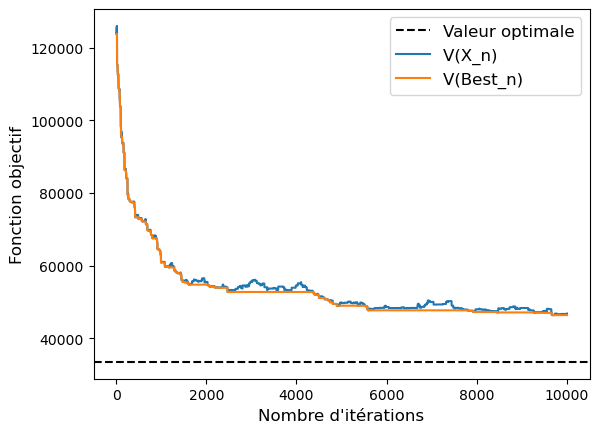

In [87]:
gap = best - V(optimal, distances)
print("La différence entre la meilleure valeur de la fonction coût trouvée par l'algorithme et la valeur optimale est", gap)
plot_recuit(cseq, bseq, best, optimal)

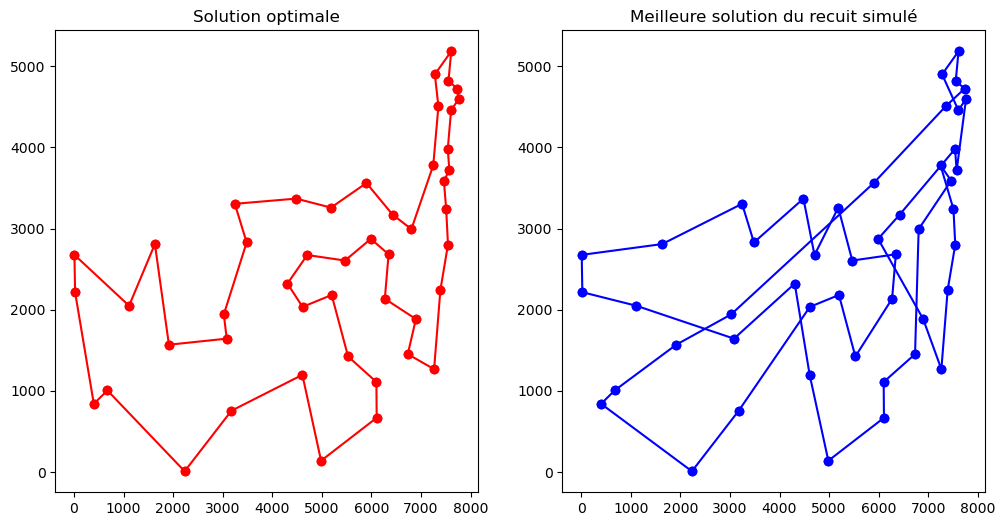

In [89]:
tt = optimal
total = len(cities)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.title('Solution optimale')
for i in range(total-1):
    plt.plot(np.array([cities[tt[i], 0], cities[tt[i+1], 0]]),
             np.array([cities[tt[i], 1], cities[tt[i+1], 1]]), '-ro')
plt.plot(np.array([cities[tt[total-1], 0], cities[tt[0], 0]]), np.array(
    [cities[tt[total-1], 1], cities[tt[0], 1]]), '-ro')

plt.subplot(1, 2, 2)
plt.title('Meilleure solution du recuit simulé')
for i in range(total-1):
    plt.plot(np.array([cities[b_tour[i], 0], cities[b_tour[i+1], 0]]),
             np.array([cities[b_tour[i], 1], cities[b_tour[i+1], 1]]), '-bo')

plt.plot(np.array([cities[b_tour[total-1], 0], cities[b_tour[0], 0]]), np.array(
    [cities[b_tour[total-1], 1], cities[b_tour[0], 1]]), '-bo')
plt.show()

## 3) Rôle de la proposition de changement

Dans la partie précédente, nous avons considéré la proposition de changement consistant à intervertir deux villes choisies au hasard. D'autres propositions sont possibles. Par exemple, au lieu d'intervertir deux villes, on peut en intervertir $k > 1$.

Une autre possibilité consiste à choisir deux villes $i,j$ au hasard et à les intervertir dans le parcours, ainsi que toutes les villes entre les deux.

**TODO** : implémenter la fonction `proposition_reverse`, qui prend un tableau d'ordre des villes et retourne un tableau permuté. Par exemple, `proposition_reverse([0, 1, 2, 3, 4, 5, 6])` pourrait produire `[0, 1, 2, 5, 4, 3, 6]`.

In [90]:
def proposition_reverse(tour):
    prop = tour.copy()
    
    i, j = np.random.choice(len(tour), size =2, replace = False)
    
    if i > j :
        i,j = j,i
        
        prop[i:j+1] = prop[i:j+1][::-1]
    
    return prop
print("Exemple :", [0,1,2,3,4,5,6], "->", proposition_reverse([0,1,2,3,4,5,6]))

Exemple : [0, 1, 2, 3, 4, 5, 6] -> [6, 5, 4, 3, 2, 1, 0]


La différence entre la meilleure valeur de la fonction coût trouvée par l'algorithme et la valeur optimale est 7145.702228172042


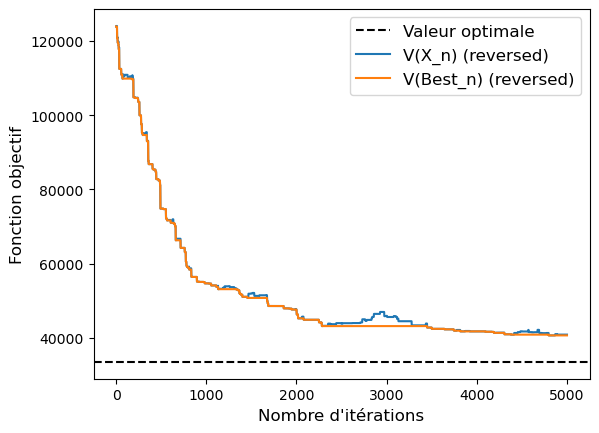

In [91]:
tour, best, cseq, bseq,b_tour = recuit_simule(distances, 5000, initial_tour, proposition_reverse, T)
gap =best - V(optimal, distances)
print("La différence entre la meilleure valeur de la fonction coût trouvée par l'algorithme et la valeur optimale est", gap)
plot_recuit(cseq, bseq, best, optimal, label="(reversed)")

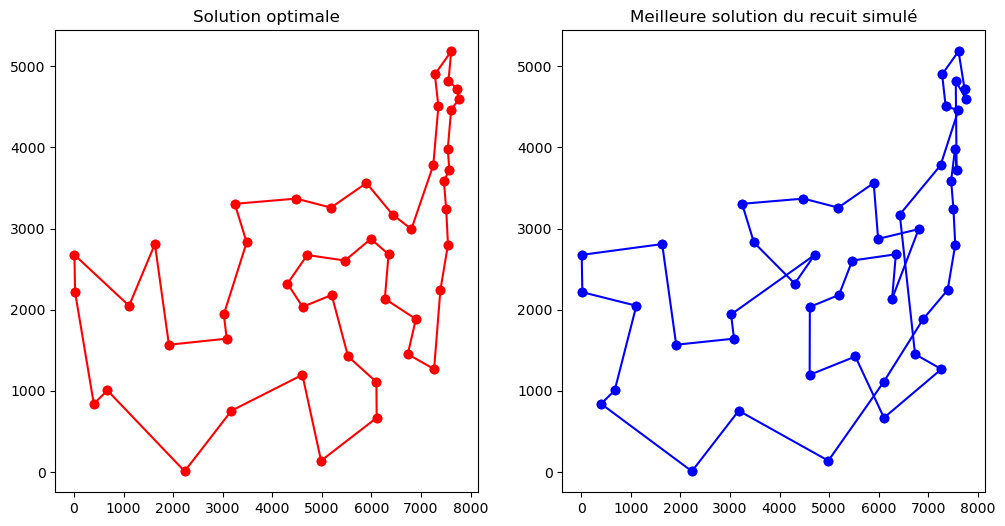

In [92]:
tt = optimal
total = len(cities)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.title('Solution optimale')
for i in range(total-1):
    plt.plot(np.array([cities[tt[i], 0], cities[tt[i+1], 0]]),
             np.array([cities[tt[i], 1], cities[tt[i+1], 1]]), '-ro')
plt.plot(np.array([cities[tt[total-1], 0], cities[tt[0], 0]]), np.array(
    [cities[tt[total-1], 1], cities[tt[0], 1]]), '-ro')

plt.subplot(1, 2, 2)
plt.title('Meilleure solution du recuit simulé')
for i in range(total-1):
    plt.plot(np.array([cities[b_tour[i], 0], cities[b_tour[i+1], 0]]),
             np.array([cities[b_tour[i], 1], cities[b_tour[i+1], 1]]), '-bo')

plt.plot(np.array([cities[b_tour[total-1], 0], cities[b_tour[0], 0]]), np.array(
    [cities[b_tour[total-1], 1], cities[b_tour[0], 1]]), '-bo')
plt.show()

Enfin, on peut raffiner la règle `proposition_reverse` pour favoriser les interversions entre sommets proches dans l'itinéraire.
Par exemple, étant donné un sommet aléatoire $i$, on choisit le sommet $j$ avec probabilité $\frac C{|i-j|+1}$, avec $C$ une constante de normalisation.

**TODO** : adapter la fonction `proposition_reverse` pour ajouter une pondération dans le choix des sommets (on pourra utiliser la fonction `np.choice`).

In [93]:
def proposition_reverse_weighted(tour):
    prop = tour.copy()
    
    i = np.random.choice(len(tour))
    
    distances = np.array([1/(abs(i-j)+1) if i != j else 0 for j in range(len(tour))])
    
    proba = distances/distances.sum()
    
    j = np.random.choice(len(tour), p =proba)
    
    if i > j :
        i, j = j , i
        
    prop[i:j+1] = prop[i:j+1][::-1]
    return prop
print("Exemple :", [0,1,2,3,4,5,6], "->", proposition_reverse_weighted([0,1,2,3,4,5,6]))

Exemple : [0, 1, 2, 3, 4, 5, 6] -> [0, 1, 2, 3, 4, 6, 5]


La différence entre la meilleure valeur de la fonction coût trouvée par l'algorithme et la valeur optimale est 3595.2513630977846


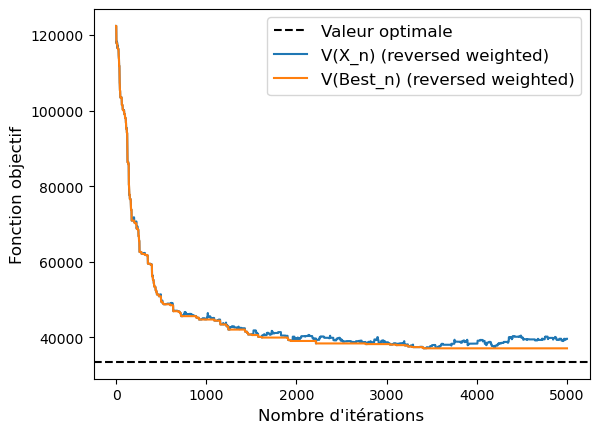

In [94]:
tour, best, cseq, bseq, b_tour = recuit_simule(distances, 5000, initial_tour, proposition_reverse_weighted, T)
gap =best - V(optimal, distances)
print("La différence entre la meilleure valeur de la fonction coût trouvée par l'algorithme et la valeur optimale est", gap)
plot_recuit(cseq, bseq, best, optimal, label="(reversed weighted)")

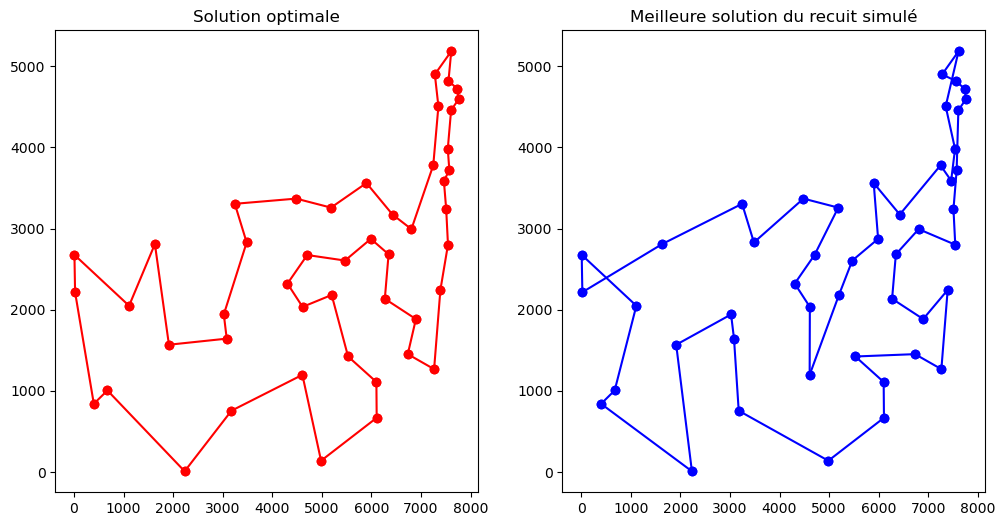

In [95]:
tt = optimal
total = len(cities)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.title('Solution optimale')
for i in range(total-1):
    plt.plot(np.array([cities[tt[i], 0], cities[tt[i+1], 0]]),
             np.array([cities[tt[i], 1], cities[tt[i+1], 1]]), '-ro')
plt.plot(np.array([cities[tt[total-1], 0], cities[tt[0], 0]]), np.array(
    [cities[tt[total-1], 1], cities[tt[0], 1]]), '-ro')

plt.subplot(1, 2, 2)
plt.title('Meilleure solution du recuit simulé')
for i in range(total-1):
    plt.plot(np.array([cities[b_tour[i], 0], cities[b_tour[i+1], 0]]),
             np.array([cities[b_tour[i], 1], cities[b_tour[i+1], 1]]), '-bo')

plt.plot(np.array([cities[b_tour[total-1], 0], cities[b_tour[0], 0]]), np.array(
    [cities[b_tour[total-1], 1], cities[b_tour[0], 1]]), '-bo')
plt.show()

Les méthodes `proposition_reverse` et `proposition_reverse_weighted` donnent des résultats proches à première vue. Pour les comparer, on effectue chaque simulation 50 fois et on compare les histogrammes des performances :

In [96]:
gaps_reverse = []
for _ in range(50):
    tour, best, cseq, bseq, b_tour = recuit_simule(distances, 5000, initial_tour, proposition_reverse, T)
    gap = best - V(optimal, distances)
    gaps_reverse.append(gap)

In [97]:
gaps_reverse_weighted = []
for _ in range(50):
    tour, best, cseq, bseq, b_tour= recuit_simule(distances, 5000, initial_tour, proposition_reverse_weighted, T)
    gap = best - V(optimal, distances)
    gaps_reverse_weighted.append(gap)

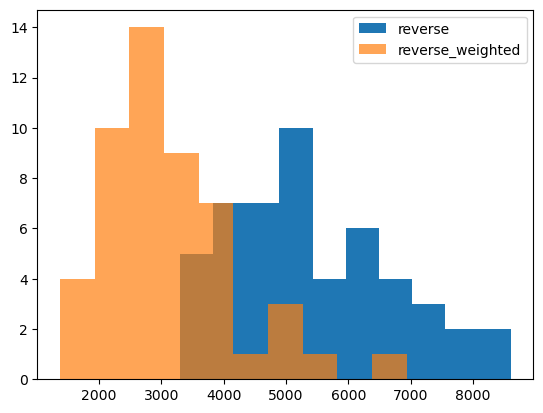

In [98]:
plt.hist(gaps_reverse ,label="reverse")
plt.hist(gaps_reverse_weighted, label="reverse_weighted", alpha=0.7)
plt.legend()
plt.show()

## 4) Schéma de température

On a utilisé jusqu'ici le schéma de température $T(i) = 300(i+1)^{-0.3}$ à décroissance polynomiale. D'autres choix sont bien sûr possibles.
On peut par exemple varier les constantes du schéma $T_{polynomial}(i) = a(i+1)^b$ :

In [99]:
def T_polynomial(a, b):
    def T(i):
        return a*((i+1)**b)
    return T

On peut maintenant tester la performance de l'algorithme du recuit simulé sur plusieurs valeurs de $a$ et $b$ :

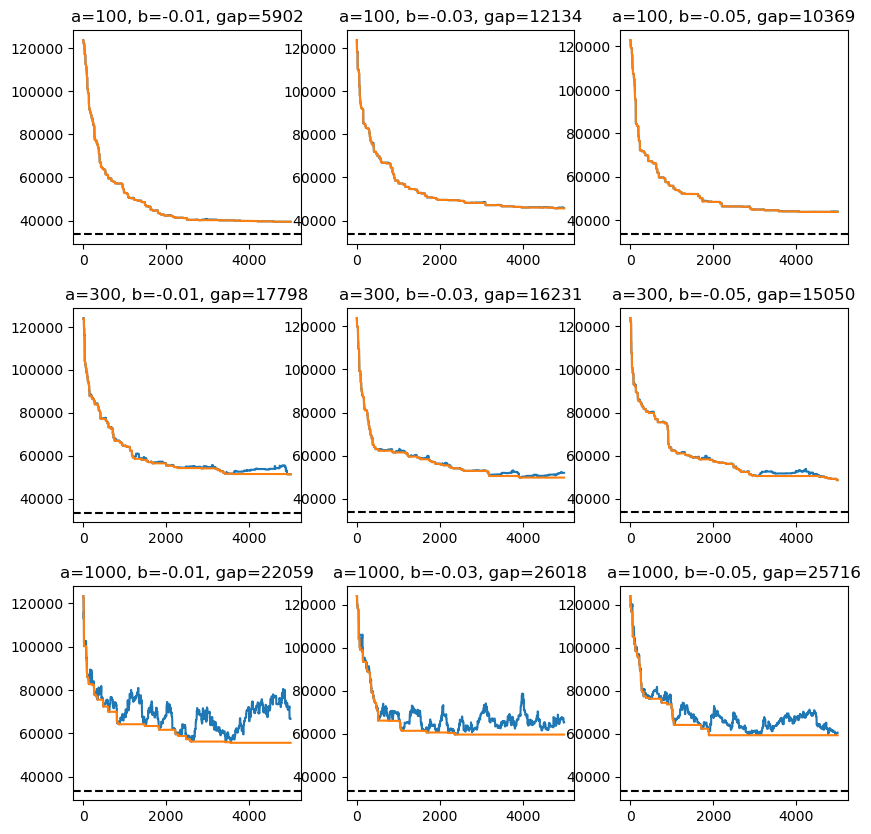

In [100]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.3)
i = 1
for a in [100, 300, 1000]:
    for b in [-0.01, -0.03, -0.05]:
        T = T_polynomial(a, b)
        tour, best, cseq, bseq, b_tour = recuit_simule(distances, 5000, initial_tour, proposition, T)
        gap = best- V(optimal, distances)
        plt.subplot(3,3,i)
        plt.title("a={}, b={}, gap={}".format(a,b,round(gap)))
        plot_recuit(cseq, bseq, best, optimal, legend=False)
        i += 1
plt.show()

A titre de comparaison, on peut également tester un schéma de température à décroissance exponentielle $T_{exponential}(i) = a*b^i$ (avec $0<b<1$).

In [101]:
def T_exponential(a, b):
    def T(i):
        return a*(b**i)
    return T

**TODO** : faire des tests similaires pour les températures exponentielles. $a$ est de l'ordre de $10^3$-$10^4$, et $b$ doit être proche de 1. Si on veut faire tourner le code pour $N_{iter} =5000$, il vaut mieux choisir $b$ entre $0.999$ et $1$ pour eviter des erreurs de compilation (overflow).

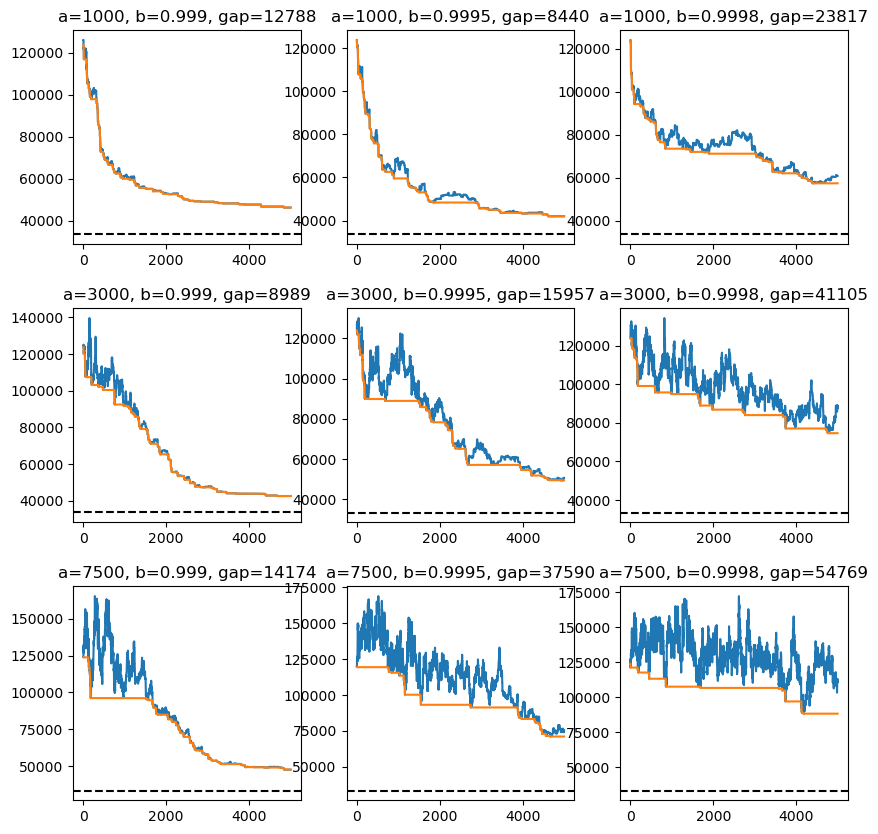

In [102]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.3)
i = 1
for a in [1000, 3000, 7500]:
    for b in [0.9990, 0.9995, 0.9998]:
        T = T_exponential(a, b)
        tour, best, cseq, bseq, b_tour = recuit_simule(distances, 5000, initial_tour, proposition, T)
        gap = best- V(optimal, distances)
        plt.subplot(3,3,i)
        plt.title("a={}, b={}, gap={}".format(a,b,round(gap)))
        plot_recuit(cseq, bseq, best, optimal, legend=False)
        i += 1
plt.show()

On peut aussi utiliser des schémas non décroissants : l'idée est alors d'alterner les phases de réchauffement et de refroidissement. On essaye ici $T_{oscillatory}(i) = a(i+1)^b(\cos((2\pi i)/c)^2+d)$.

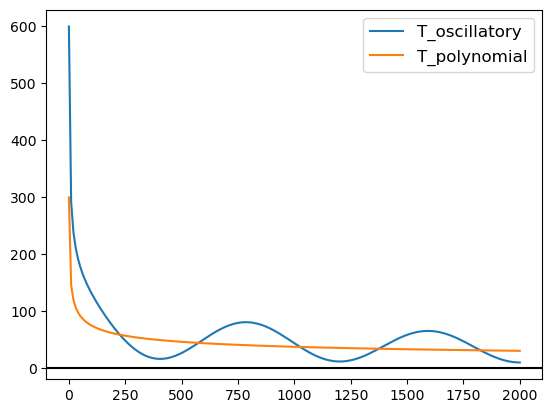

In [103]:
def T_oscillatory(a, b, c, d):
    def T(i):
        return a*((i+1)**b)*(np.cos(2*np.pi*i/c)**2 + d)
    return T

x = np.linspace(0,2000,200)
plt.plot(x, T_oscillatory(500,-0.3,1600,0.2)(x), label="T_oscillatory")
plt.plot(x, T_polynomial(300,-0.3)(x), label="T_polynomial")
plt.axhline(0, c="black")
plt.legend(fontsize=12)
plt.show()

**TODO** : observer le comportement du schéma de température oscillant et l'influence des paramètres du schéma sur le résultat.

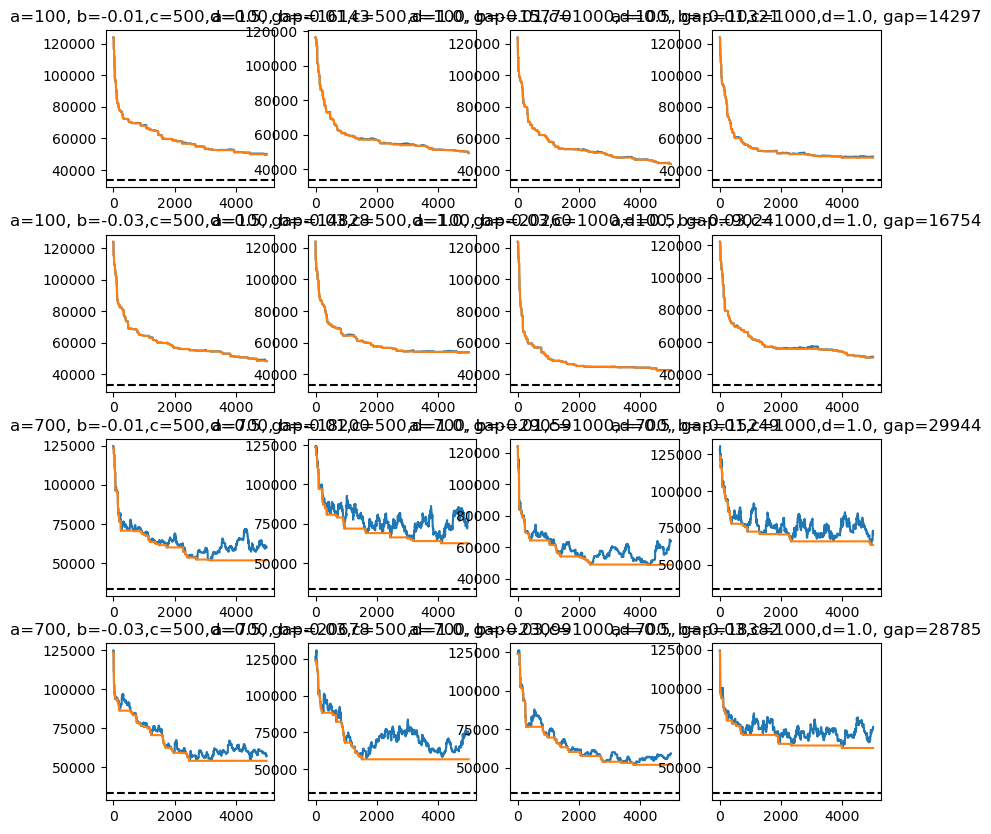

In [104]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.3)


a_values = [100, 700]  
b_values = [-0.01, -0.03]  
c_values = [500, 1000]  
d_values = [0.5, 1.0]  



i = 1
for a in a_values:
    for b in b_values:
        for c in c_values:
            for d in d_values:
                T = T_oscillatory(a, b, c, d)
                
                tour, best, cseq, bseq, b_tour = recuit_simule(distances, 5000, initial_tour, proposition, T)
                gap = best- V(optimal, distances)
                plt.subplot(len(a_values)*len(b_values),len(c_values)*len(d_values),i)
                plt.title("a={}, b={},c={},d={}, gap={}".format(a,b,c,d,round(gap)))
                plot_recuit(cseq, bseq, best, optimal, legend=False)
                i += 1
plt.show()


## 5) Pour aller plus loin...

Vous pouvez tester l'algorithme sur des instances plus difficiles. Les données sont organisées comme celles du problème `us_capitals`.
- Le problème `gr96` consiste à calculer le plus court cycle reliant 96 villes en Afrique
- Le problème `tsp225` relie 225 villes générées automatiquement

Dans le jeux de données `gr96`, les villes sont données en coordonnées sphériques (latitude, longitude). Pour calculer les distances entre villes, on utilise la fonction `earth_dist`, définie ci-dessous à l'aide du module `geopy` ([disponible](https://pypi.org/project/geopy/) via `pip`) :

In [105]:
!pip install geopy

In [106]:
from geopy import distance

def earth_dist(citya, cityb):
    return distance.distance(citya, cityb).miles

In [107]:
gr96_list = np.genfromtxt("gr96.csv", delimiter=",")
gr96_opt = np.genfromtxt("gr96_opt.csv", delimiter=",").astype(int)-1
gr96_distances = np.array([[earth_dist(ca, cb) for ca in gr96_list] for cb in gr96_list])

In [108]:
tsp225_list = np.genfromtxt("tsp225.csv", delimiter=",")
tsp225_opt = np.genfromtxt("tsp225_opt.csv", delimiter=",").astype(int)-1
tsp225_distances = np.array([[euclidian_dist(ca, cb) for ca in tsp225_list] for cb in tsp225_list])

In [109]:
cities = gr96_list
optimal = gr96_opt
distances = gr96_distances

#### Avec proposition uniforme et un modèle de température polynomial décroissant

In [110]:
problem_initial_tours = []
for i in range(10):
    problem_initial_tours.append(optimal.copy())
    for k in range(i):
        problem_initial_tours[i] = proposition(problem_initial_tours[i])

In [111]:
N_iter = 10000
i = 8
initial_tour = problem_initial_tours[i]

tour, best, cseq, bseq,b_tour = recuit_simule(distances, N_iter, initial_tour, proposition, T)

La différence entre la meilleure valeur de la fonction coût trouvée par l'algorithme et la valeur optimale est 35729.725562120424


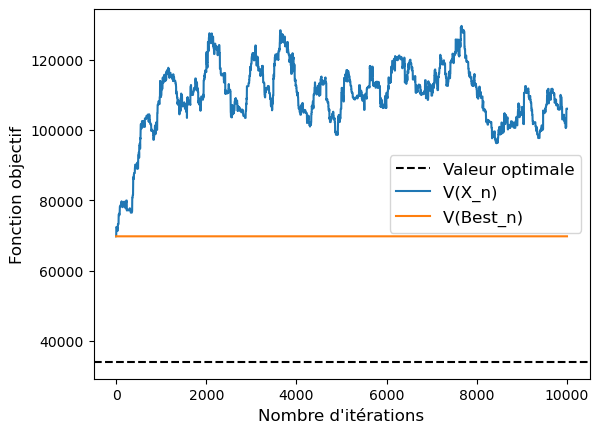

In [112]:
gap = best - V(optimal, distances)
print("La différence entre la meilleure valeur de la fonction coût trouvée par l'algorithme et la valeur optimale est", gap)
plot_recuit(cseq, bseq, best, optimal)

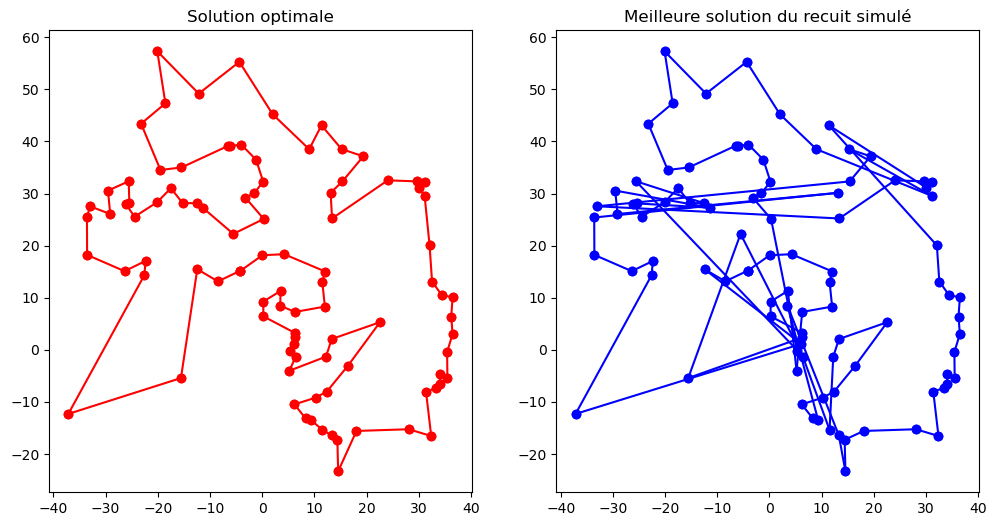

In [113]:
tt = optimal
total = len(cities)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.title('Solution optimale')
for i in range(total-1):
    plt.plot(np.array([cities[tt[i], 0], cities[tt[i+1], 0]]),
             np.array([cities[tt[i], 1], cities[tt[i+1], 1]]), '-ro')
plt.plot(np.array([cities[tt[total-1], 0], cities[tt[0], 0]]), np.array(
    [cities[tt[total-1], 1], cities[tt[0], 1]]), '-ro')

plt.subplot(1, 2, 2)
plt.title('Meilleure solution du recuit simulé')
for i in range(total-1):
    plt.plot(np.array([cities[b_tour[i], 0], cities[b_tour[i+1], 0]]),
             np.array([cities[b_tour[i], 1], cities[b_tour[i+1], 1]]), '-bo')

plt.plot(np.array([cities[b_tour[total-1], 0], cities[b_tour[0], 0]]), np.array(
    [cities[b_tour[total-1], 1], cities[b_tour[0], 1]]), '-bo')
plt.show()

#### Avec proposition reverse

La différence entre la meilleure valeur de la fonction coût trouvée par l'algorithme et la valeur optimale est 35729.725562120424


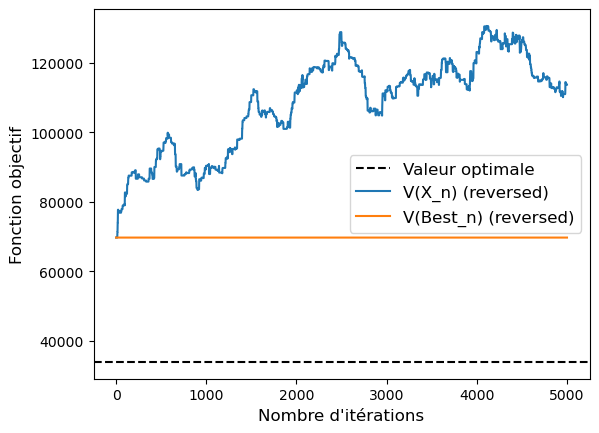

In [114]:
tour, best, cseq, bseq,b_tour = recuit_simule(distances, 5000, initial_tour, proposition_reverse, T)
gap =best - V(optimal, distances)
print("La différence entre la meilleure valeur de la fonction coût trouvée par l'algorithme et la valeur optimale est", gap)
plot_recuit(cseq, bseq, best, optimal, label="(reversed)")

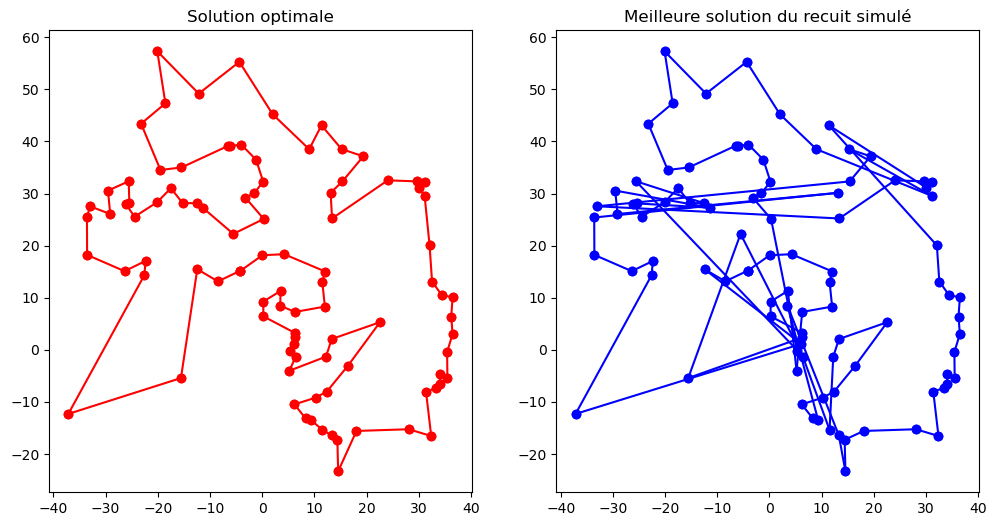

In [115]:
tt = optimal
total = len(cities)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.title('Solution optimale')
for i in range(total-1):
    plt.plot(np.array([cities[tt[i], 0], cities[tt[i+1], 0]]),
             np.array([cities[tt[i], 1], cities[tt[i+1], 1]]), '-ro')
plt.plot(np.array([cities[tt[total-1], 0], cities[tt[0], 0]]), np.array(
    [cities[tt[total-1], 1], cities[tt[0], 1]]), '-ro')

plt.subplot(1, 2, 2)
plt.title('Meilleure solution du recuit simulé')
for i in range(total-1):
    plt.plot(np.array([cities[b_tour[i], 0], cities[b_tour[i+1], 0]]),
             np.array([cities[b_tour[i], 1], cities[b_tour[i+1], 1]]), '-bo')

plt.plot(np.array([cities[b_tour[total-1], 0], cities[b_tour[0], 0]]), np.array(
    [cities[b_tour[total-1], 1], cities[b_tour[0], 1]]), '-bo')
plt.show()

#### Avec proposition reverse raffinée

La différence entre la meilleure valeur de la fonction coût trouvée par l'algorithme et la valeur optimale est 35729.725562120424


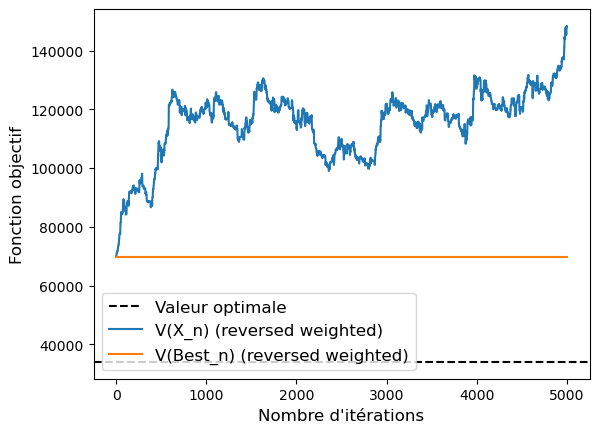

In [116]:
tour, best, cseq, bseq, b_tour = recuit_simule(distances, 5000, initial_tour, proposition_reverse_weighted, T)
gap =best - V(optimal, distances)
print("La différence entre la meilleure valeur de la fonction coût trouvée par l'algorithme et la valeur optimale est", gap)
plot_recuit(cseq, bseq, best, optimal, label="(reversed weighted)")

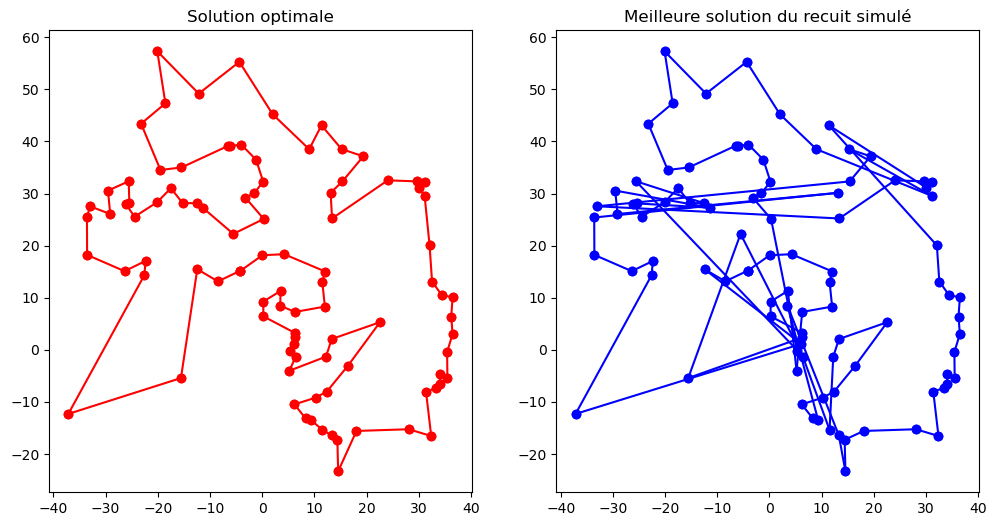

In [117]:
tt = optimal
total = len(cities)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.title('Solution optimale')
for i in range(total-1):
    plt.plot(np.array([cities[tt[i], 0], cities[tt[i+1], 0]]),
             np.array([cities[tt[i], 1], cities[tt[i+1], 1]]), '-ro')
plt.plot(np.array([cities[tt[total-1], 0], cities[tt[0], 0]]), np.array(
    [cities[tt[total-1], 1], cities[tt[0], 1]]), '-ro')

plt.subplot(1, 2, 2)
plt.title('Meilleure solution du recuit simulé')
for i in range(total-1):
    plt.plot(np.array([cities[b_tour[i], 0], cities[b_tour[i+1], 0]]),
             np.array([cities[b_tour[i], 1], cities[b_tour[i+1], 1]]), '-bo')

plt.plot(np.array([cities[b_tour[total-1], 0], cities[b_tour[0], 0]]), np.array(
    [cities[b_tour[total-1], 1], cities[b_tour[0], 1]]), '-bo')
plt.show()

In [118]:
gaps_reverse = []
for _ in range(50):
    tour, best, cseq, bseq, b_tour = recuit_simule(distances, 5000, initial_tour, proposition_reverse, T)
    gap = best - V(optimal, distances)
    gaps_reverse.append(gap)

In [119]:
gaps_reverse_weighted = []
for _ in range(50):
    tour, best, cseq, bseq, b_tour= recuit_simule(distances, 5000, initial_tour, proposition_reverse_weighted, T)
    gap = best - V(optimal, distances)
    gaps_reverse_weighted.append(gap)

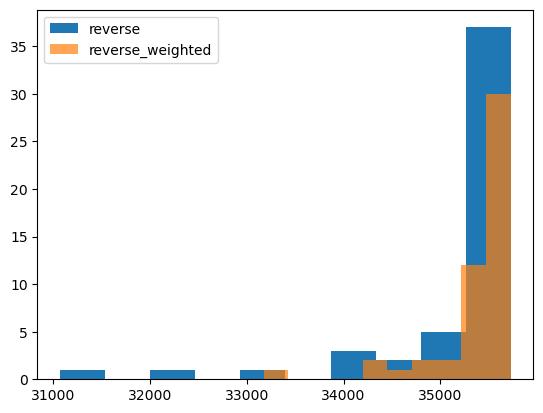

In [120]:
plt.hist(gaps_reverse ,label="reverse")
plt.hist(gaps_reverse_weighted, label="reverse_weighted", alpha=0.7)
plt.legend()
plt.show()

### schema de temperature

#### profil de temperature polynômiale

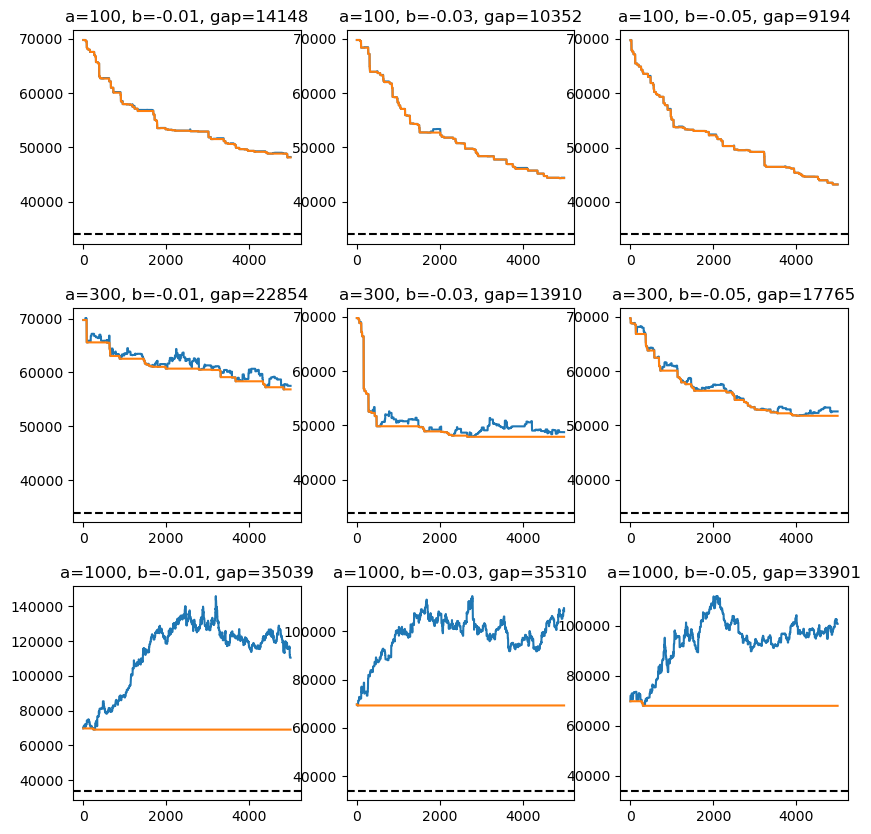

In [121]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.3)
i = 1
for a in [100, 300, 1000]:
    for b in [-0.01, -0.03, -0.05]:
        T = T_polynomial(a, b)
        tour, best, cseq, bseq, b_tour = recuit_simule(distances, 5000, initial_tour, proposition, T)
        gap = best- V(optimal, distances)
        plt.subplot(3,3,i)
        plt.title("a={}, b={}, gap={}".format(a,b,round(gap)))
        plot_recuit(cseq, bseq, best, optimal, legend=False)
        i += 1
plt.show()

#### Profil de température exponentiel 

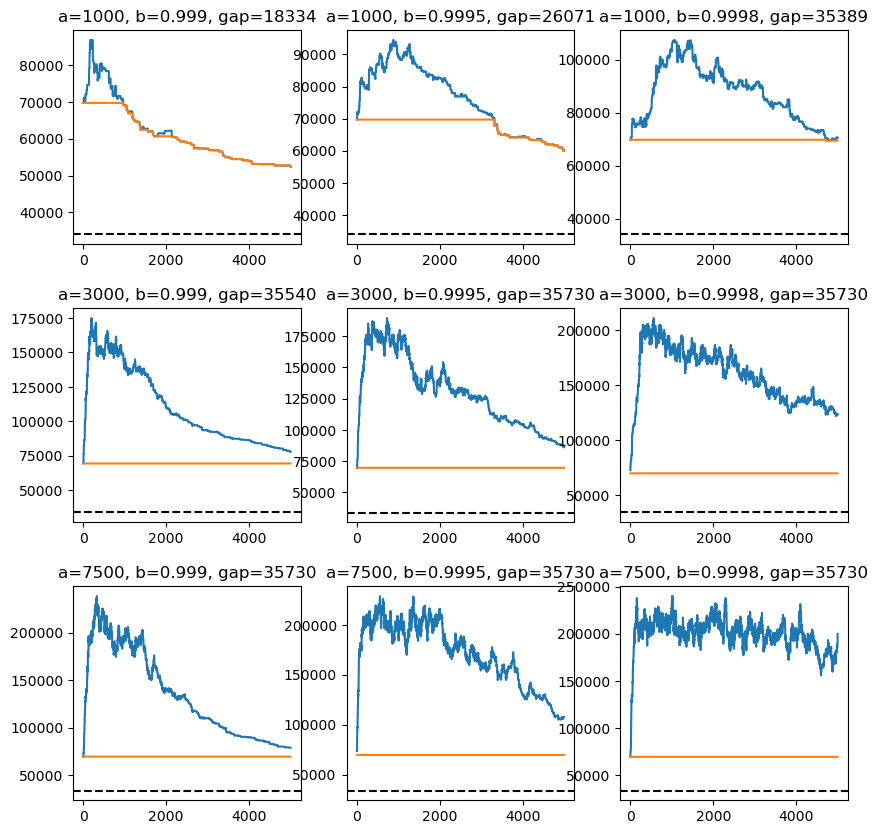

In [122]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.3)
i = 1
for a in [1000, 3000, 7500]:
    for b in [0.9990, 0.9995, 0.9998]:
        T = T_exponential(a, b)
        tour, best, cseq, bseq, b_tour = recuit_simule(distances, 5000, initial_tour, proposition, T)
        gap = best- V(optimal, distances)
        plt.subplot(3,3,i)
        plt.title("a={}, b={}, gap={}".format(a,b,round(gap)))
        plot_recuit(cseq, bseq, best, optimal, legend=False)
        i += 1
plt.show()

#### Température oscillante

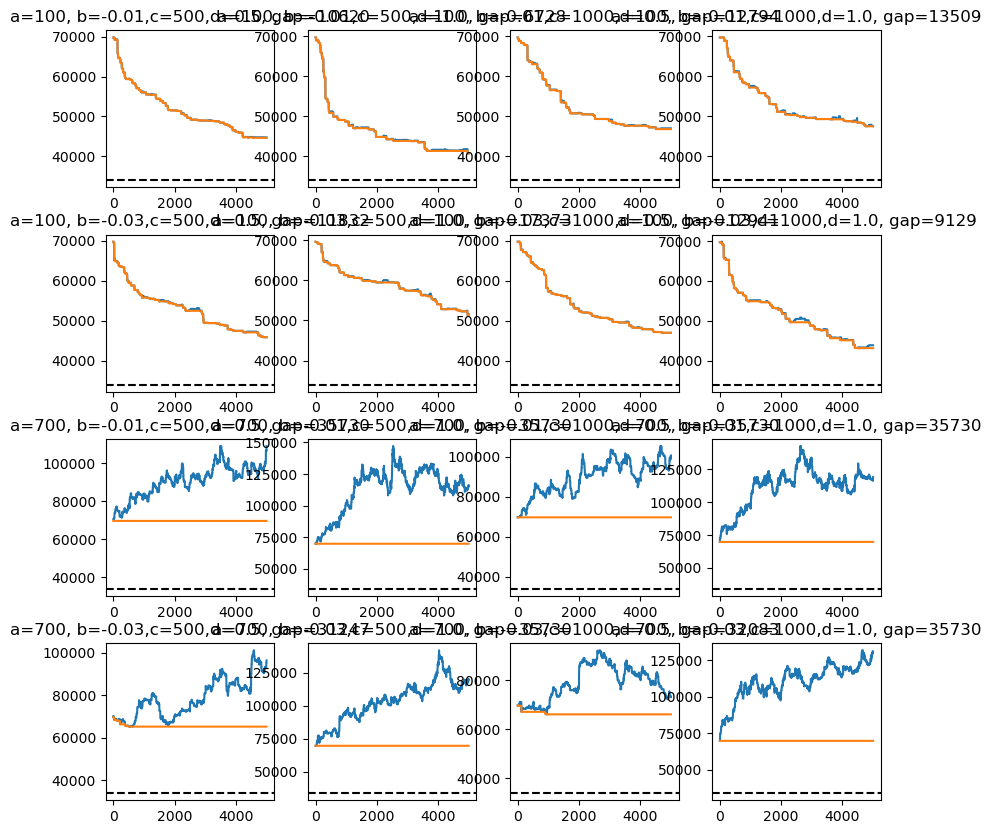

In [123]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.3)


a_values = [100, 700]  
b_values = [-0.01, -0.03]  
c_values = [500, 1000]  
d_values = [0.5, 1.0]  



i = 1
for a in a_values:
    for b in b_values:
        for c in c_values:
            for d in d_values:
                T = T_oscillatory(a, b, c, d)
                
                tour, best, cseq, bseq, b_tour = recuit_simule(distances, 5000, initial_tour, proposition, T)
                gap = best- V(optimal, distances)
                plt.subplot(len(a_values)*len(b_values),len(c_values)*len(d_values),i)
                plt.title("a={}, b={},c={},d={}, gap={}".format(a,b,c,d,round(gap)))
                plot_recuit(cseq, bseq, best, optimal, legend=False)
                i += 1
plt.show()

#### Cas du dataset tsp225

In [124]:
cities = tsp225_list
optimal = tsp225_opt
distances = tsp225_distances

#### Avec proposition uniforme et modèle de température décroissant 

In [125]:
problem_initial_tours = []
for i in range(10):
    problem_initial_tours.append(optimal.copy())
    for k in range(i):
        problem_initial_tours[i] = proposition(problem_initial_tours[i])

In [126]:
N_iter = 10000
i = 8
initial_tour = problem_initial_tours[i]

tour, best, cseq, bseq,b_tour = recuit_simule(distances, N_iter, initial_tour, proposition, T)

La différence entre la meilleure valeur de la fonction coût trouvée par l'algorithme et la valeur optimale est 3902.6495346992897


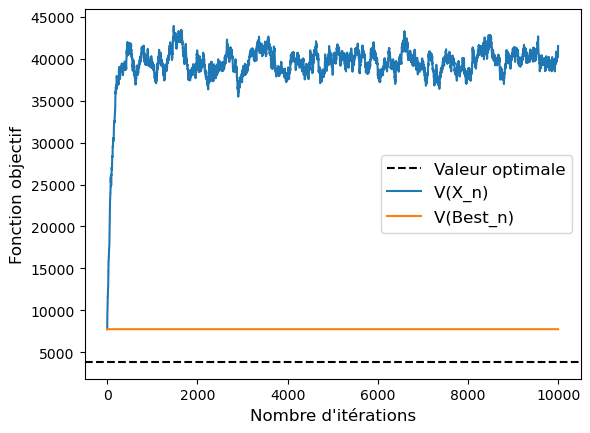

In [127]:
gap = best - V(optimal, distances)
print("La différence entre la meilleure valeur de la fonction coût trouvée par l'algorithme et la valeur optimale est", gap)
plot_recuit(cseq, bseq, best, optimal)

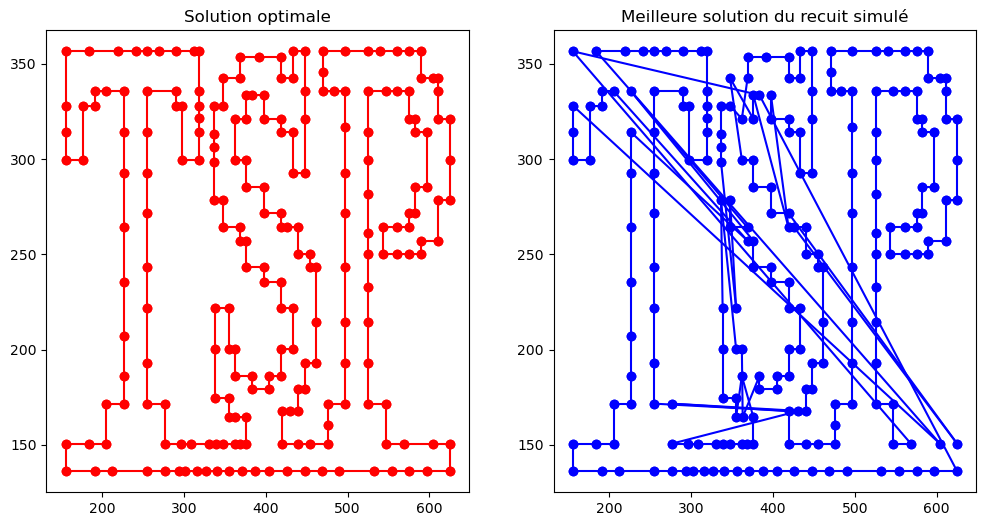

In [128]:
tt = optimal
total = len(cities)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.title('Solution optimale')
for i in range(total-1):
    plt.plot(np.array([cities[tt[i], 0], cities[tt[i+1], 0]]),
             np.array([cities[tt[i], 1], cities[tt[i+1], 1]]), '-ro')
plt.plot(np.array([cities[tt[total-1], 0], cities[tt[0], 0]]), np.array(
    [cities[tt[total-1], 1], cities[tt[0], 1]]), '-ro')

plt.subplot(1, 2, 2)
plt.title('Meilleure solution du recuit simulé')
for i in range(total-1):
    plt.plot(np.array([cities[b_tour[i], 0], cities[b_tour[i+1], 0]]),
             np.array([cities[b_tour[i], 1], cities[b_tour[i+1], 1]]), '-bo')

plt.plot(np.array([cities[b_tour[total-1], 0], cities[b_tour[0], 0]]), np.array(
    [cities[b_tour[total-1], 1], cities[b_tour[0], 1]]), '-bo')
plt.show()

#### Avec proposition reverse

La différence entre la meilleure valeur de la fonction coût trouvée par l'algorithme et la valeur optimale est 3902.6495346992897


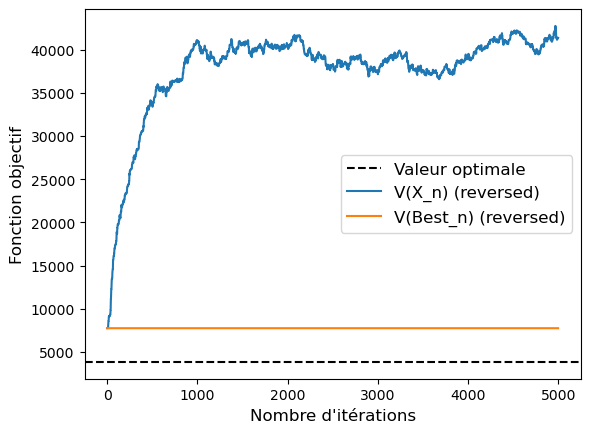

In [129]:
tour, best, cseq, bseq,b_tour = recuit_simule(distances, 5000, initial_tour, proposition_reverse, T)
gap =best - V(optimal, distances)
print("La différence entre la meilleure valeur de la fonction coût trouvée par l'algorithme et la valeur optimale est", gap)
plot_recuit(cseq, bseq, best, optimal, label="(reversed)")

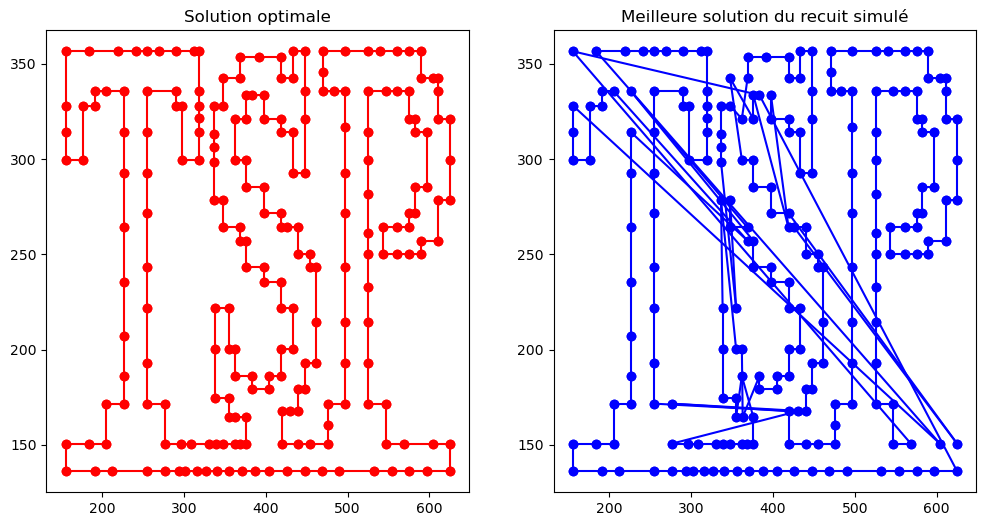

In [136]:
tt = optimal
total = len(cities)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.title('Solution optimale')
for i in range(total-1):
    plt.plot(np.array([cities[tt[i], 0], cities[tt[i+1], 0]]),
             np.array([cities[tt[i], 1], cities[tt[i+1], 1]]), '-ro')
plt.plot(np.array([cities[tt[total-1], 0], cities[tt[0], 0]]), np.array(
    [cities[tt[total-1], 1], cities[tt[0], 1]]), '-ro')

plt.subplot(1, 2, 2)
plt.title('Meilleure solution du recuit simulé')
for i in range(total-1):
    plt.plot(np.array([cities[b_tour[i], 0], cities[b_tour[i+1], 0]]),
             np.array([cities[b_tour[i], 1], cities[b_tour[i+1], 1]]), '-bo')

plt.plot(np.array([cities[b_tour[total-1], 0], cities[b_tour[0], 0]]), np.array(
    [cities[b_tour[total-1], 1], cities[b_tour[0], 1]]), '-bo')
plt.show()

#### Avec reverse raffinée

La différence entre la meilleure valeur de la fonction coût trouvée par l'algorithme et la valeur optimale est 3902.6495346992897


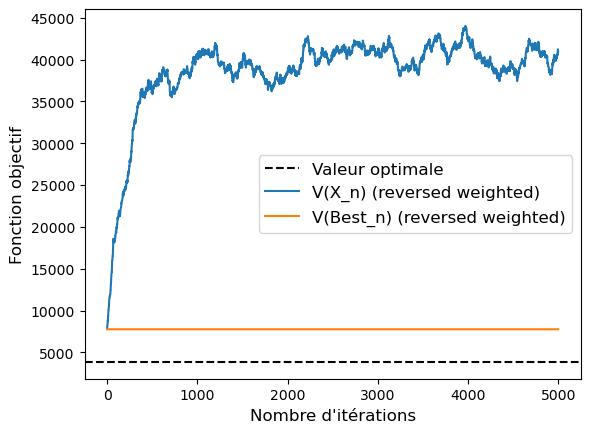

In [130]:
tour, best, cseq, bseq, b_tour = recuit_simule(distances, 5000, initial_tour, proposition_reverse_weighted, T)
gap =best - V(optimal, distances)
print("La différence entre la meilleure valeur de la fonction coût trouvée par l'algorithme et la valeur optimale est", gap)
plot_recuit(cseq, bseq, best, optimal, label="(reversed weighted)")

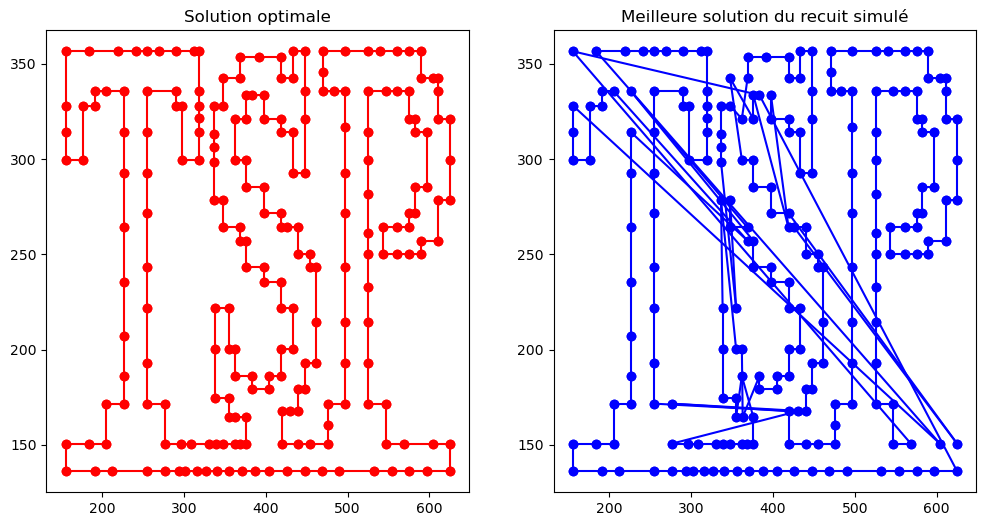

In [137]:
tt = optimal
total = len(cities)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.title('Solution optimale')
for i in range(total-1):
    plt.plot(np.array([cities[tt[i], 0], cities[tt[i+1], 0]]),
             np.array([cities[tt[i], 1], cities[tt[i+1], 1]]), '-ro')
plt.plot(np.array([cities[tt[total-1], 0], cities[tt[0], 0]]), np.array(
    [cities[tt[total-1], 1], cities[tt[0], 1]]), '-ro')

plt.subplot(1, 2, 2)
plt.title('Meilleure solution du recuit simulé')
for i in range(total-1):
    plt.plot(np.array([cities[b_tour[i], 0], cities[b_tour[i+1], 0]]),
             np.array([cities[b_tour[i], 1], cities[b_tour[i+1], 1]]), '-bo')

plt.plot(np.array([cities[b_tour[total-1], 0], cities[b_tour[0], 0]]), np.array(
    [cities[b_tour[total-1], 1], cities[b_tour[0], 1]]), '-bo')
plt.show()

In [131]:
gaps_reverse = []
for _ in range(50):
    tour, best, cseq, bseq, b_tour = recuit_simule(distances, 5000, initial_tour, proposition_reverse, T)
    gap = best - V(optimal, distances)
    gaps_reverse.append(gap)

In [132]:
gaps_reverse_weighted = []
for _ in range(50):
    tour, best, cseq, bseq, b_tour= recuit_simule(distances, 5000, initial_tour, proposition_reverse_weighted, T)
    gap = best - V(optimal, distances)
    gaps_reverse_weighted.append(gap)

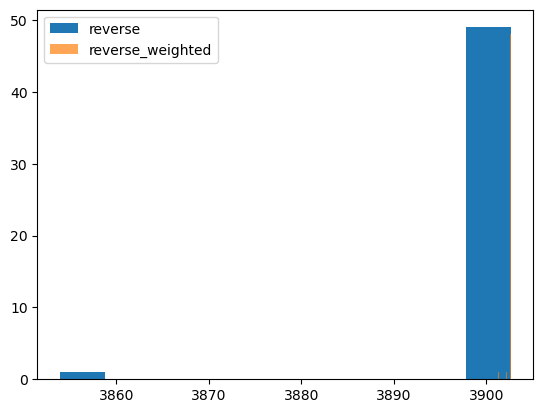

In [133]:
plt.hist(gaps_reverse ,label="reverse")
plt.hist(gaps_reverse_weighted, label="reverse_weighted", alpha=0.7)
plt.legend()
plt.show()

###  Schema de temperature

#### Temperature polynomiale

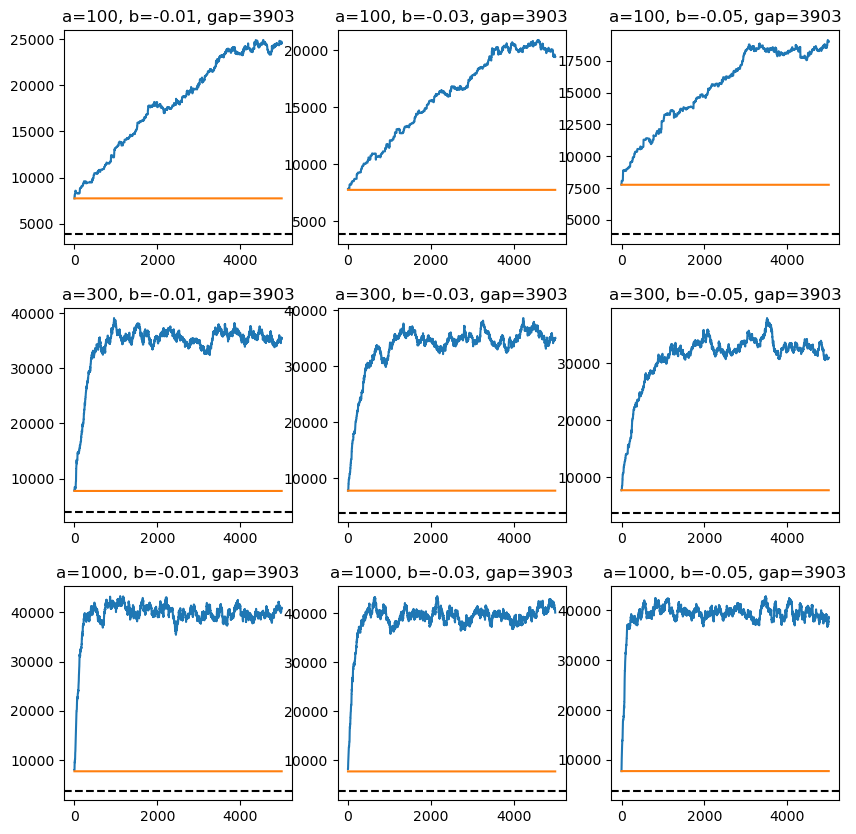

In [135]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.3)
i = 1
for a in [100, 300, 1000]:
    for b in [-0.01, -0.03, -0.05]:
        T = T_polynomial(a, b)
        tour, best, cseq, bseq, b_tour = recuit_simule(distances, 5000, initial_tour, proposition, T)
        gap = best- V(optimal, distances)
        plt.subplot(3,3,i)
        plt.title("a={}, b={}, gap={}".format(a,b,round(gap)))
        plot_recuit(cseq, bseq, best, optimal, legend=False)
        i += 1
plt.show()

#### temperature exponentielle

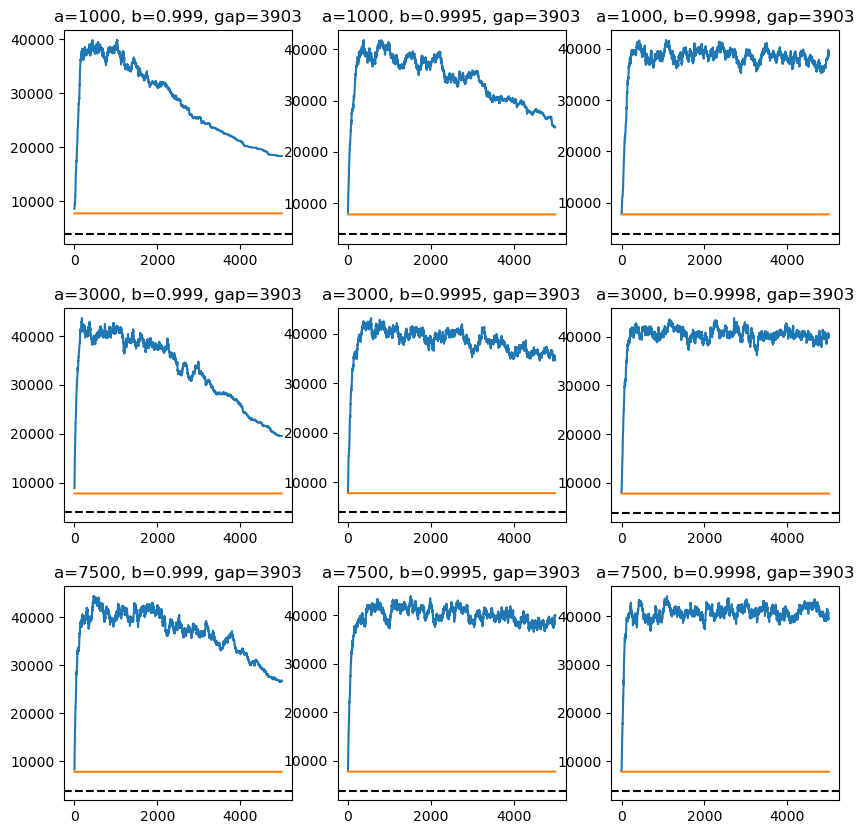

In [138]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.3)
i = 1
for a in [1000, 3000, 7500]:
    for b in [0.9990, 0.9995, 0.9998]:
        T = T_exponential(a, b)
        tour, best, cseq, bseq, b_tour = recuit_simule(distances, 5000, initial_tour, proposition, T)
        gap = best- V(optimal, distances)
        plt.subplot(3,3,i)
        plt.title("a={}, b={}, gap={}".format(a,b,round(gap)))
        plot_recuit(cseq, bseq, best, optimal, legend=False)
        i += 1
plt.show()

#### temperature oscillante

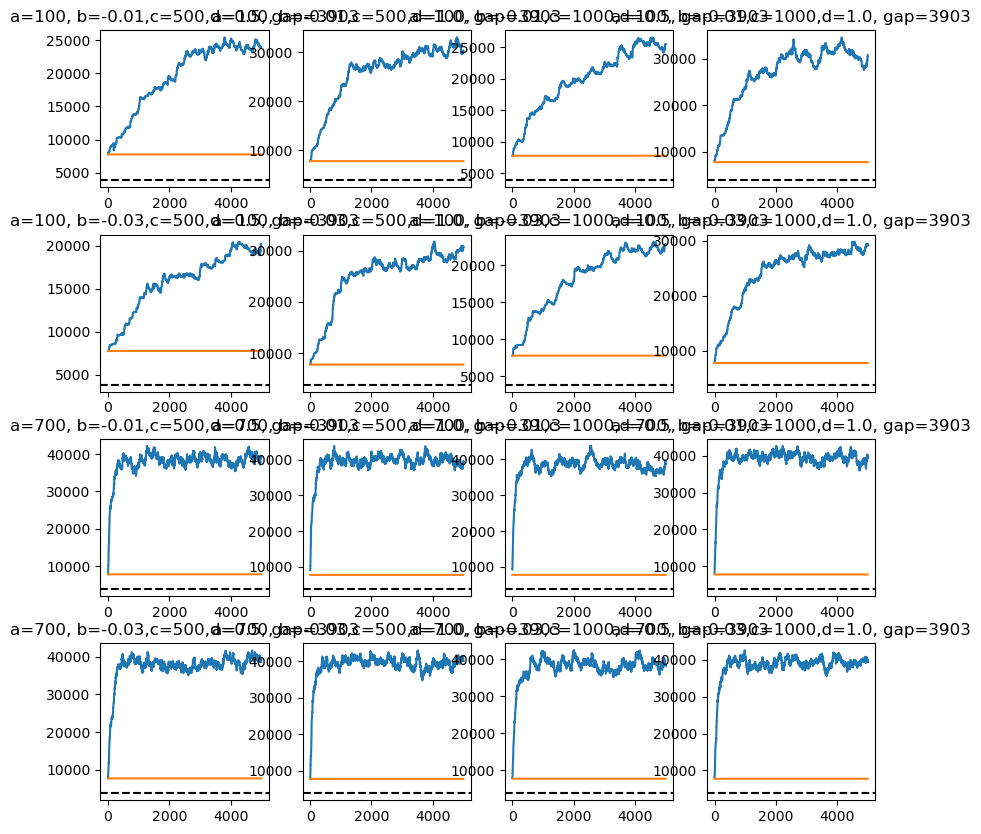

In [139]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.3)


a_values = [100, 700]  
b_values = [-0.01, -0.03]  
c_values = [500, 1000]  
d_values = [0.5, 1.0]  



i = 1
for a in a_values:
    for b in b_values:
        for c in c_values:
            for d in d_values:
                T = T_oscillatory(a, b, c, d)
                
                tour, best, cseq, bseq, b_tour = recuit_simule(distances, 5000, initial_tour, proposition, T)
                gap = best- V(optimal, distances)
                plt.subplot(len(a_values)*len(b_values),len(c_values)*len(d_values),i)
                plt.title("a={}, b={},c={},d={}, gap={}".format(a,b,c,d,round(gap)))
                plot_recuit(cseq, bseq, best, optimal, legend=False)
                i += 1
plt.show()

## 6) Conclusions
1. Que fait l'algorithme du recuit simulé ? Pour quels types de problèmes est-il pertinent ?

#### Fonctionnement de l'algorithme :
Le recuit simulé est une méthode d'optimisation probabiliste inspirée du processus de recuit en métallurgie, où un métal est chauffé puis refroidi lentement pour atteindre un état de basse énergie. L'algorithme utilise une exploration aléatoire de l'espace des solutions et accepte des solutions qui ne sont pas nécessairement meilleures, avec une probabilité qui diminue au fur et à mesure du refroidissement (via une température décroissante).

Étapes principales :
- Partir d'une solution initiale.
- Proposer une solution voisine en effectuant une légère modification.
- Évaluer le coût (ou l'énergie) de cette nouvelle solution.
- Accepter ou rejeter cette solution en fonction d'une probabilité qui dépend de la différence de coût et de la température actuelle.
- Réduire la température progressivement (refroidissement).
- Répéter jusqu'à ce que la température atteigne un seuil ou qu'un critère d'arrêt soit atteint.
#### Problèmes pour lesquels il est pertinent :
##### Problèmes d'optimisation combinatoire :
Exemple : Problème du voyageur de commerce (TSP), allocation de ressources, planification, routage.
##### Problèmes non convexes :
Lorsqu'il y a plusieurs minima locaux et qu'une simple descente de gradient est insuffisante.
##### Problèmes où l'espace de recherche est vaste :
Par exemple, trouver des configurations optimales dans des graphes ou des systèmes physiques.


2. Quel est le rôle de la proposition de changement ? Comment la choisir ?

#### Rôle :
La proposition de changement génère une solution voisine de la solution actuelle. Elle permet d'explorer l'espace des solutions. Si elle est trop conservatrice, l'algorithme risque de rester bloqué dans un minimum local ; si elle est trop radicale, l'algorithme peut manquer des bonnes solutions locales.

#### Considérations pour choisir une bonne proposition :
- Exploration locale :

La proposition doit modifier légèrement la solution actuelle pour explorer les solutions proches (par exemple, échanger deux villes dans le TSP).
- Aléatoire mais contrôlée :

Une bonne proposition doit introduire de la variété sans changer complètement la structure de la solution. Par exemple, dans un problème de routage, échanger deux arcs voisins est une approche raisonnable.
- Adaptée au problème :

Pour des problèmes structurés (comme le TSP), choisir une règle qui respecte les contraintes du problème (pas de doublons, rester dans l'espace des solutions valides).
- Complexité computationnelle :

Le calcul d'une proposition doit être rapide, car l'algorithme effectue souvent un grand nombre d'itérations.

3. Quel est le rôle du schéma de température ? Comment le choisir ?

La température contrôle la probabilité d'accepter des solutions moins bonnes. Au début, une température élevée favorise l'exploration en permettant d'accepter plus facilement des solutions sous-optimales (pour éviter un piégeage prématuré). Avec une température plus basse, l'algorithme se concentre sur l'exploitation, c'est-à-dire l'amélioration locale autour de la meilleure solution trouvée.